# Offender Recidivism

## Introduction

During my time getting my Bachelor's in Computer Science, I picked up a minor in Criminal Justice and finished it last semester. During my last class for my minor, we did some data analytics in R regarding all types of crime data. We never got to predicting data, only visualizing and making bivariate regressions. While I'm done completing my minor, this topic is still interesting to me, and I'd like to see if I could use models to predict whether offenders reoffended or not within 3 years.

For project 2, I'm going to be looking at offender recidivism and attempting to create a model to predict recidivism given crime characteristics and release information of real offenders provided by the State of Iowa.

## The Question

The problem that I would like to solve this project is:
<ul>
    <li>Can it be predicted if an offender will return to prison within 3 years?</li>
</ul>

## The Data

The data I'm using for this project is from the State of Iowa, found through this Kaggle post <a href="https://www.kaggle.com/datasets/slonnadube/recidivism-for-offenders-released-from-prison?resource=download">here.</a>

I'm just using one of the csv files, as the second one is redudant and has a few more columns I'm not interested in.

This data set includes a column at the end with a 1 or 0 value to indicate whether an offender has returned to prison or not (1 meaning they returned, 0 they have not).

In [1]:
import pandas as pd
import numpy as np

In [2]:
recidivism_df = pd.read_csv("3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa_elaborated.csv")

In [3]:
recidivism_df

,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Release type: Paroled to Detainder united,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White - Non-Hispanic,Under 25,D Felony,Violent,Assault,4JD,Parole,Parole,Yes,1
1,2010,2013,White - Non-Hispanic,55 and Older,D Felony,Public Order,OWI,7JD,Parole,Parole,Yes,1
2,2010,2013,White - Non-Hispanic,25-34,D Felony,Property,Burglary,5JD,Parole,Parole,Yes,1
3,2010,2013,White - Non-Hispanic,55 and Older,C Felony,Drug,Trafficking,8JD,Parole,Parole,Yes,1
4,2010,2013,Black - Non-Hispanic,25-34,D Felony,Drug,Trafficking,3JD,Parole,Parole,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...
26015,2015,2018,White - Hispanic,25-34,C Felony,Violent,Murder/Manslaughter,NaN,Discharged End of Sentence,Discharged End of Sentence,Yes,0
26016,2015,2018,White - Non-Hispanic,25-34,D Felony,Property,Vandalism,5JD,Paroled to Detainer - Out of State,Paroled to Detainer,No,0
26017,2015,2018,Black - Non-Hispanic,Under 25,Aggravated Misdemeanor,Violent,Other Violent,1JD,Discharged End of Sentence,Discharged End of Sentence,Yes,0
26018,2015,2018,White - Non-Hispanic,Under 25,D Felony,Drug,Other Drug,5JD,Parole,Parole,No,0


## Pre-Processing

Luckily with this dataset, there's not much pre-processing to do, but I'm still going to inspect my data and remove unnecessary columns. I'm keeping Release type: Paroled to Detainder united versus Release Type because it's more concise in the rows and combines similar types of release.

In [4]:
recidivism_cleaned_df = recidivism_df.drop(['Fiscal Year Released', 'Recidivism Reporting Year', 
                                            'Main Supervising District', 'Release Type', 
                                            'Part of Target Population'], axis=1)

In [5]:
#checking for null values
recidivism_cleaned_df.isna().sum()

Race - Ethnicity                               30
Age At Release                                  3
Convicting Offense Classification               0
Convicting Offense Type                         0
Convicting Offense Subtype                      0
Release type: Paroled to Detainder united    1762
Recidivism - Return to Prison numeric           0
dtype: int64

In a frame with just over 26,000 rows, I'm fine with dropping all the rows with these null values. I want to include all of these rows in the model, and if it had full data it'll be able to train and perform better.

In [6]:
recidivism_cleaned_df = recidivism_cleaned_df.dropna(axis=0)

In [11]:
recidivism_cleaned_df.isna().sum()

Race - Ethnicity                             0
Age At Release                               0
Convicting Offense Classification            0
Convicting Offense Type                      0
Convicting Offense Subtype                   0
Release type: Paroled to Detainder united    0
Recidivism - Return to Prison numeric        0
dtype: int64

In [12]:
recidivism_cleaned_df.dtypes

Race - Ethnicity                             object
Age At Release                               object
Convicting Offense Classification            object
Convicting Offense Type                      object
Convicting Offense Subtype                   object
Release type: Paroled to Detainder united    object
Recidivism - Return to Prison numeric         int64
dtype: object

Now that our data is cleaned, it's time to start understanding it.

## Data Understanding / Visualization

Before I get into modeling the data for classification, I want to visualize the data and see a few things. Apologies for the excessive circles but I like pie charts.

The first will be how many offenders in this dataset reoffended in the first place?

In [49]:
import matplotlib.pyplot as plt

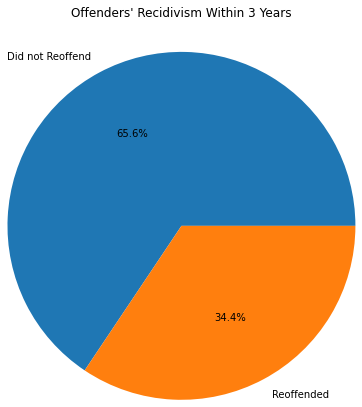

In [103]:
labels = ['Did not Reoffend', 'Reoffended']
data = recidivism_cleaned_df['Recidivism - Return to Prison numeric'].value_counts()
plt.pie(data, labels=labels, autopct='%1.1f%%', radius=2)
plt.title('Offenders\' Recidivism Within 3 Years', pad=100)
plt.show()

Just from this pie graph, we can see that around 1/3 of offenders reoffended within 3 years.

Let's now look at what types of crimes the reoffenders initially committed before they were released. For this, I'm just looking at the top 6 classifications, as I've discovered after trying to get a good look at this graph there are a few classifications with less than 1% of reoffenders that aren't common in the dataset.

In [96]:
reoffender_df = recidivism_cleaned_df[recidivism_cleaned_df['Recidivism - Return to Prison numeric'] != 0]
reoffender_df['Recidivism - Return to Prison numeric'].value_counts()

1    8331
Name: Recidivism - Return to Prison numeric, dtype: int64

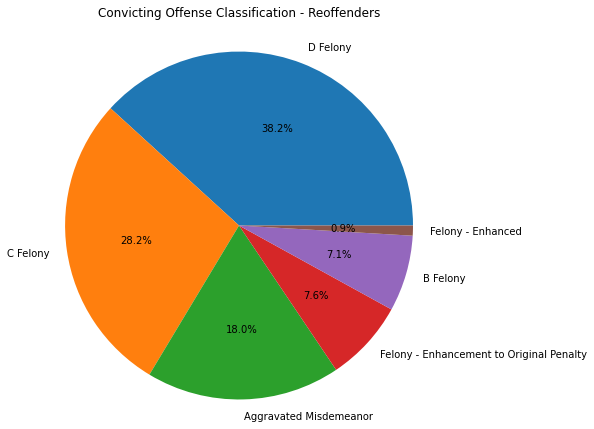

In [101]:
#first looking at classification of crime (felony, misdemeanor, etc)
data = reoffender_df['Convicting Offense Classification'].value_counts().nlargest(6)
labels = data.index
plt.pie(data, labels=labels, autopct='%1.1f%%', radius=2)
plt.title('Convicting Offense Classification - Reoffenders', pad=100)
plt.show()

The common theme for reoffenders seems to be mostly a Felony. Let's explore those who did not reoffend and their initial convictions.

In [100]:
no_reoffender_df = recidivism_cleaned_df[recidivism_cleaned_df['Recidivism - Return to Prison numeric'] != 1]
no_reoffender_df['Recidivism - Return to Prison numeric'].value_counts()

0    15894
Name: Recidivism - Return to Prison numeric, dtype: int64

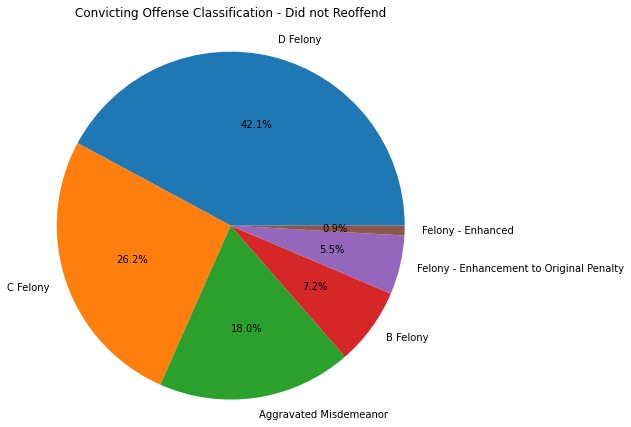

In [102]:
data = no_reoffender_df['Convicting Offense Classification'].value_counts().nlargest(6)
labels = data.index
plt.pie(data, labels=labels, autopct='%1.1f%%', radius=2)
plt.title('Convicting Offense Classification - Did not Reoffend', pad=100)
plt.show()

Surprisingly, it's a very similar chart. Perhaps we need to look into other aspects.

Now I'm going to investigate release type - this would be answering a question regarding the type of release that an offender had. Does more supervision (aka Parole release versus finishing a sentence) stop an offender from reoffending?

I'll use my split dataframes to show reoffender vs no reoffender.

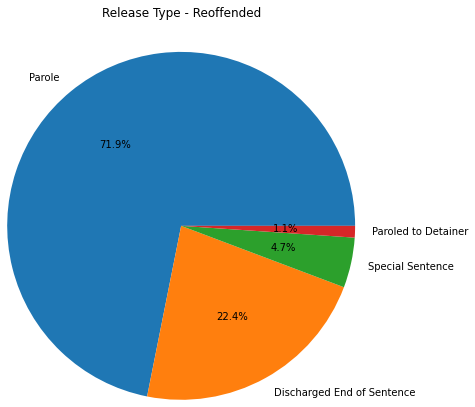

In [104]:
data = reoffender_df['Release type: Paroled to Detainder united'].value_counts()
labels = data.index
plt.pie(data, labels=labels, autopct='%1.1f%%', radius=2)
plt.title('Release Type - Reoffended', pad=100)
plt.show()

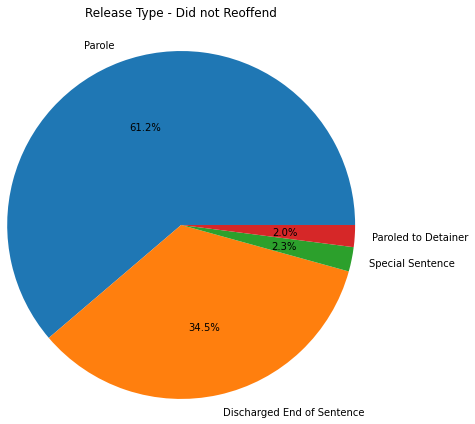

In [105]:
data = no_reoffender_df['Release type: Paroled to Detainder united'].value_counts()
labels = data.index
plt.pie(data, labels=labels, autopct='%1.1f%%', radius=2)
plt.title('Release Type - Did not Reoffend', pad=100)
plt.show()

This data is interesting to me. It seems for reoffenders, more of them were released initally on Parole than being discharged at the end of their sentence. This leads to a question that came up quite a bit in my minor studies - does being supervised more make you reoffend more, or do officers just notice more crimes when someone is under supervision? This data can't answer that, but it'll be useful for the models.

I'm going to add more charts/visualizations:

Comparing Age and Ethnicity of Reoffenders/Non-Reoffenders

## Modeling

Now that I've looked at some of the data and visualized some key characteristics, I want to use models to predict our data.

The models I'm going to be using are:
<ul>
    <li>Random Forest</li>
    <li>Naive Bayes</li>
    <li>More? Maybe SVM?</li>
</ul>